In [13]:
# Torch
import torch
from torch.utils.data import DataLoader
from torch.distributions import Normal, Uniform

# SBI
from sbi.analysis import pairplot
from sbi.inference import NPE
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from sbi.utils import BoxUniform, MultipleIndependent
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import CNNEmbedding

# Others
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import corner
import pickle

# Custom
from training.data_loader import load_data
from analysis.visualization_utils import plot_corner, plot_corner_overlay, plot_corner_image, plot_parity, plot_coverage
from analysis.diagnostic_utils import get_coverage

# Colors
stanford_red = '#8C1515'
stanford_red_light = '#B83A4B'
stanford_green = '#175E54'
stanford_green_light = '#2D716F'
stanford_grey = '#53565A'
stanford_brown = '#5D4B3C'
stanford_brown_light ='#766253'
stanford_stone = '#7F7776'
stanford_fog = '#DAD7CB'
stanford_blue = '#016895'
stanford_blue_light = '#4298B5'
stanford_orange = '#E98300'
stanford_orange_light = '#F9A44A'
stanford_purple = '#620059'
stanford_purple_light = '#734675'

In [12]:
# Load data
train_dir = "/Users/steven/Desktop/WinterRotation/sbi-stronglensing/datasets/train_3/"
val_dir = "/Users/steven/Desktop/WinterRotation/sbi-stronglensing/datasets/validation/"

keep_columns = [
    "main_deflector_parameters_theta_E",
    "main_deflector_parameters_gamma1",
    "main_deflector_parameters_gamma2",
    "main_deflector_parameters_gamma",
    "main_deflector_parameters_e1",
    "main_deflector_parameters_e2",
    "main_deflector_parameters_center_x",
    "main_deflector_parameters_center_y",
    "source_parameters_center_x",
    "source_parameters_center_y"
    ]

param_names = [r'$\theta_\mathrm{E}$',r'$\gamma_1$',r'$\gamma_2$',r'$\gamma_\mathrm{lens}$',r'$e_1$',
               r'$e_2$',r'$x_\mathrm{lens}$',r'$y_\mathrm{lens}$',r'$x_\mathrm{src}$',r'$y_\mathrm{src}$']

theta_train, x_train = load_data(train_dir, keep_columns)
theta_val, x_val = load_data(val_dir, keep_columns)

In [3]:
# Load posteriors
maf_path = "/Users/steven/Desktop/WinterRotation/sbi-stronglensing/models/maf/maf_cnn_2025-03-17_19-36-16/posterior.pkl"
mdn_path = "/Users/steven/Desktop/WinterRotation/sbi-stronglensing/models/mdn/mdn_cnn_2025-03-17_22-49-09/posterior.pkl"
nsf_path = "/Users/steven/Desktop/WinterRotation/sbi-stronglensing/models/nsf/nsf_cnn_2025-03-17_19-56-35/posterior.pkl"


with open(maf_path, "rb") as handle:
    posterior_maf = pickle.load(handle)

with open(mdn_path, "rb") as handle:
    posterior_mdn = pickle.load(handle)

with open(nsf_path, "rb") as handle:
    posterior_nsf = pickle.load(handle)


In [7]:
# Sampling
theta_obs = theta_val[:100]
x_obs = x_val[:100]
samples_maf = posterior_maf.sample_batched((10000,), x=x_obs)
samples_mdn = posterior_mdn.sample_batched((10000,), x=x_obs)
samples_nsf = posterior_nsf.sample_batched((10000,), x=x_obs)

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [06:51<00:00, 24.32it/s]


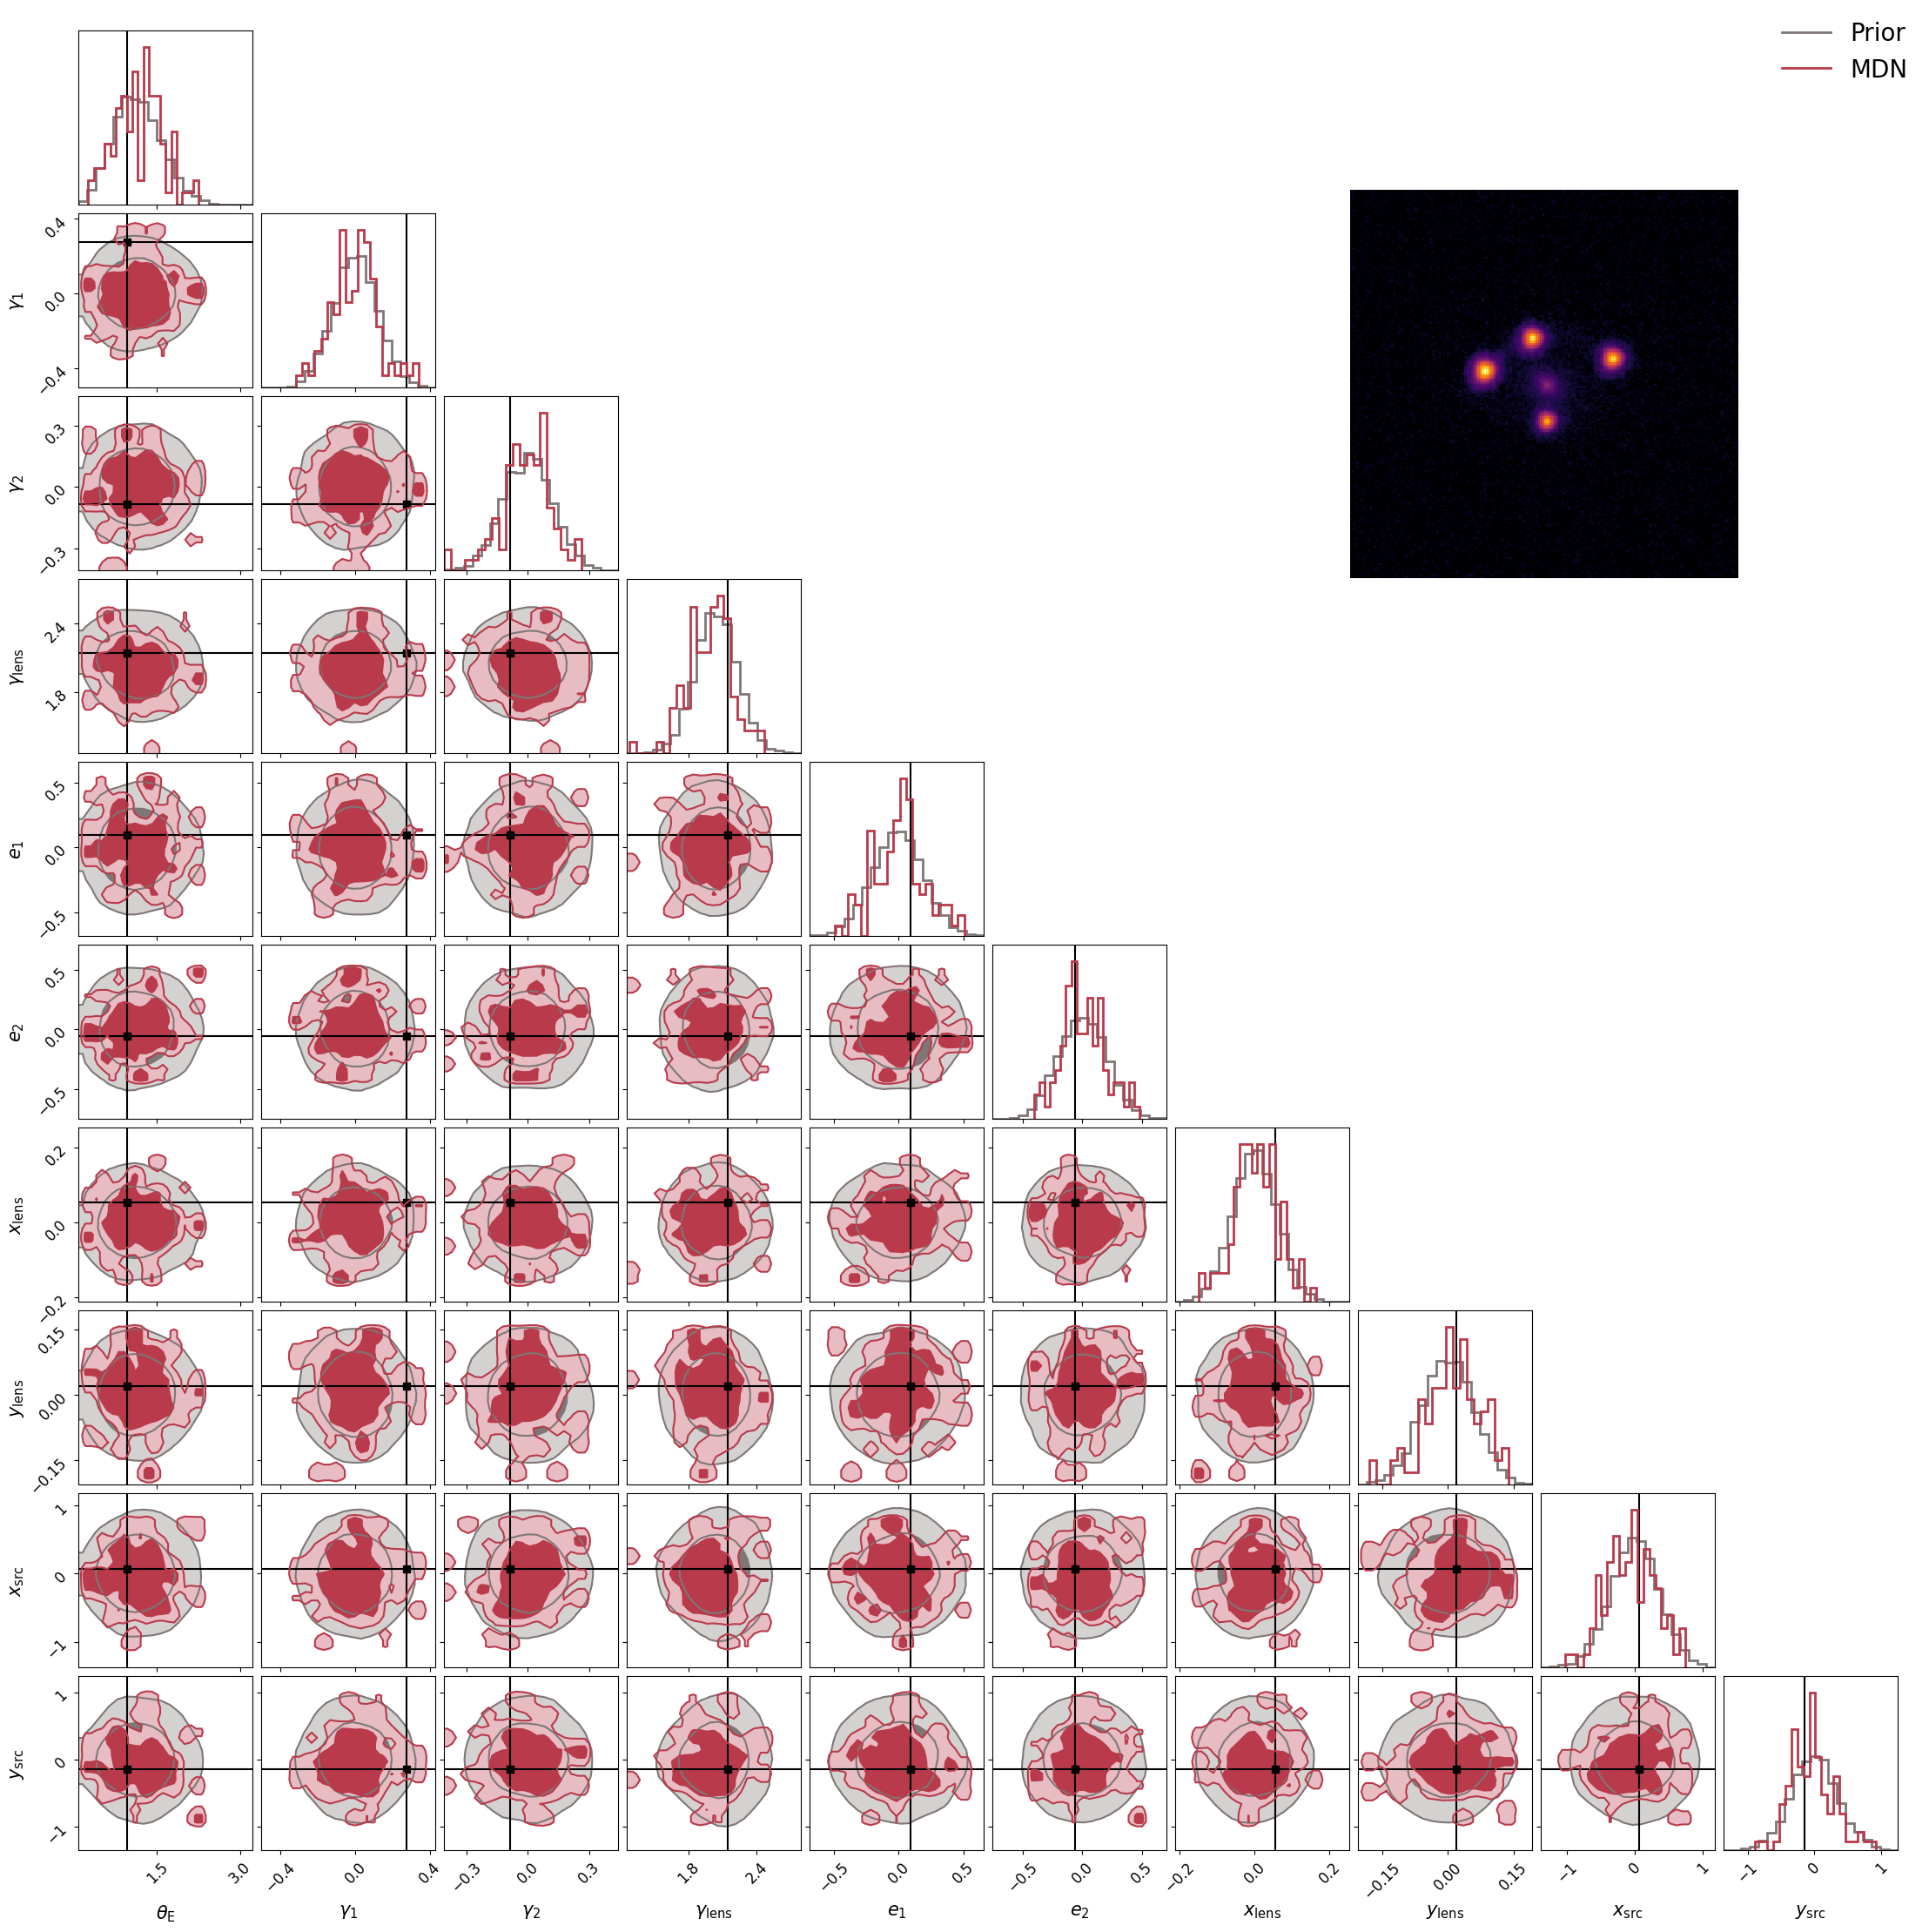

In [18]:
# Plot corner
import matplotlib.colors as mcolors
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', ['black', stanford_brown_light, 'white'])

# Sample one
i = 99
samples_one_maf = samples_maf[i]
samples_one_mdn = samples_mdn[i]
samples_one_nsf = samples_nsf[i]
truths = theta_obs[i]

# 
f = plot_corner(np.array(theta_val), np.array(truths), param_names, stanford_stone, show_titles=False, legend_label='Prior')
f = plot_corner_overlay(f, np.array(samples_one_mdn), stanford_red_light, legend_label='MDN')
# f = plot_corner_overlay(f, np.array(samples_one_maf), stanford_red_light, legend_label='MAF')
# f = plot_corner_overlay(f, np.array(samples_one_nsf), stanford_blue_light, legend_label='NSF')
f = plot_corner_image(f, x_obs[i].numpy(), position=(0.7, 0.7, 0.2, 0.2), cmap='inferno')